In [74]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf
import tensorflow.keras.layers as layers
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from somoclu import Somoclu
from skimage.util import random_noise


img_height = 100
img_width = 100
total_sample = 1900
rng = np.random.default_rng(1)


In [27]:
class LVQ:
    """
    Learning Vector Quantization
    """

    def __init__(self, weights: np.ndarray, lr=1e-3, epochs=100, random_state=1):
        self.lr = lr
        self.epochs = epochs
        self.rng = np.random.default_rng(random_state)
        self.weights_ = weights

    def fit(self, X: np.ndarray, y: np.ndarray):
        assert X.shape[1] == self.weights_.shape[1], "X.shape[1] != self.weights_.shape[1]"

        for i in tqdm.trange(self.epochs):
            self.rng.shuffle(X)
            for sample, label in zip(X, y):
                winner = np.argmin(np.linalg.norm(
                    self.weights_ - sample, axis=1))
                sign = 1 if winner == label else -1
                self.weights_[winner] += sign*self.lr * \
                    (sample - self.weights_[winner])
            self.lr = self.lr * 1/np.sqrt(i+1)
        return self

    def predict(self, X: np.ndarray):
        y_pred = np.zeros(X.shape[0], dtype=np.int32)
        for i, sample in enumerate(X):
            y_pred[i] = np.argmin(np.linalg.norm(
                self.weights_ - sample, axis=1))
        return y_pred




In [28]:
def sort_codebook(som: Somoclu, kmeans: KMeans, X: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Sort codebook by label
    """
    custom_c = np.zeros_like(kmeans.cluster_centers_)
    for i in range(num_classes):
        X_ = X[y == i].astype(np.float32)
        # y_ = y[y == i]
        idx, count = np.unique(kmeans.predict(X_), return_index=True)
        c = idx[np.argmax(count)]
        custom_c[i] = kmeans.cluster_centers_[c]
    return custom_c


In [29]:
data = image_dataset_from_directory(
    directory='Dataset/',
    interpolation='nearest',
    batch_size=1,
    shuffle=False,
    image_size=(img_height, img_width),
    color_mode='grayscale',
    follow_links=False,
)


class_names = data.class_names
num_classes = len(class_names)


Found 1900 files belonging to 19 classes.


In [30]:
X = np.zeros((total_sample, img_height*img_width))
y = np.zeros(total_sample, dtype=np.int32)
for i, (img, label) in enumerate(data):
    X[i] = img.numpy().flatten()
    y[i] = label.numpy()

X = 255 - X
X = X*(1.0/255.0)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

In [43]:
width, height, step = 20, 20, 1
som = Somoclu(width, height, gridtype='rectangular', std_coeff=0.1, verbose=0)
som.train(X_train, epochs=10)
# codebook = som._weights.reshape(som._weights.shape[1], -1).copy()

# fig = plt.figure(figsize=(20, 20))
# for i in range(0, width, step):
#     for j in range(0, height, step):
#         ax = fig.add_subplot(width, height, i*height+j+1)
#         ax.imshow(som._weights[i, j].reshape(
#             img_height, img_width), cmap='gray')
#         ax.axis('off')


In [44]:
kmeans = KMeans(n_clusters=num_classes)
som.cluster(algorithm=kmeans)

In [45]:
som.clusters

array([[17, 18, 18, 18, 14, 14, 11,  4,  4,  4, 11,  2, 11, 11, 11,  4,
        11, 11,  6,  2],
       [18, 18, 18, 18,  4,  4,  4,  4,  4, 14, 11,  2,  2, 11,  3,  4,
         4,  4,  2,  2],
       [15, 18, 18,  4,  3,  3, 11,  2,  1,  1,  2,  2,  4,  4,  4,  4,
         4,  4, 18, 18],
       [ 3, 11, 18, 18,  3,  3,  2, 11, 11,  1,  4,  2, 11, 11, 11, 14,
        15, 18, 18, 18],
       [12,  3,  2,  2,  3,  3,  3,  5, 17, 17, 18,  6, 11, 11, 14, 14,
        11, 15, 15, 18],
       [15, 18, 18, 18, 18,  3,  5,  5,  9, 17, 18, 11, 11, 11,  4,  4,
         3,  5, 17,  4],
       [11, 18, 18,  4, 18,  4,  3,  5,  5, 10, 11, 11,  4, 14,  4,  4,
         4,  4,  4,  4],
       [ 4,  4,  4,  4,  4,  3, 15,  6, 11, 11,  1, 11,  1,  4, 15,  4,
         3,  4,  4,  4],
       [ 4,  4,  4,  4, 18, 15, 15,  6, 11, 11, 16,  8,  8,  3,  3,  3,
         3,  4, 11, 11],
       [14,  4,  4, 18, 18, 15, 15, 11, 14, 14, 14, 11, 15, 15,  3, 15,
         1, 11, 11, 11],
       [ 4,  4, 11, 18, 11, 15

In [46]:
kmeans.cluster_centers_

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 3.1512616e-05,  6.3980151e-05,  2.6737973e-05, ...,
         7.3211268e-05,  4.0739775e-05,  5.3474680e-05],
       [ 9.0949470e-13, -1.8189894e-12,  7.2759576e-12, ...,
         3.0920226e-03,  3.0920208e-03,  3.0920235e-03],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-9.0949470e-13, -1.8189894e-12, -7.2759576e-12, ...,
         8.8770062e-02,  8.8770047e-02,  8.8770069e-02],
       [ 3.6379788e-12,  0.0000000e+00,  3.9215692e-04, ...,
         6.3480390e-03,  6.2499959e-03,  6.4460784e-03]], dtype=float32)

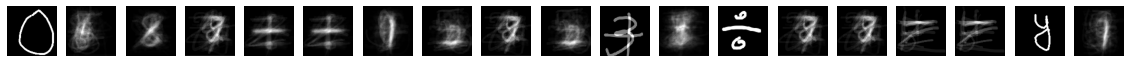

In [47]:
codebook = sort_codebook(som, kmeans, X, y)
fig = plt.figure(figsize=(20, 20))
for i in range(1):
    for j in range(19):
        ax = fig.add_subplot(10, 19, i*1+j+1)
        ax.imshow(codebook[i*19+j].reshape(
            img_height, img_width), cmap='gray')
        ax.axis('off')

In [48]:
rng = np.random.default_rng(1)
# random_codebook = rng.random((19, img_height*img_width), dtype=np.float32)
lvq = LVQ(codebook, lr=0.01, epochs=100, random_state=1)
lvq.fit(X_train.copy(), y_train)


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


In [78]:
y_pred = lvq.predict(X_train)

print("classification report (train):")
print("f1:",f1_score(y_train, y_pred, average='macro'))
print("recall:", recall_score(y_train, y_pred, average='macro'))
print("precision:",precision_score(y_train, y_pred, average='macro'))
print("accuracy:", accuracy_score(y_train, y_pred))

classification report (train):
f1: 0.4341891945421683
recall: 0.4346824489577495
precision: 0.43410287458396113
accuracy: 0.4342105263157895


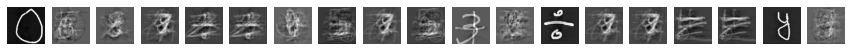

In [50]:
fig = plt.figure(figsize=(15, 15))
for i in range(1):
    for j in range(19):
        ax = fig.add_subplot(1, 19, i*19+j+1)
        ax.imshow(lvq.weights_[j].reshape(img_height, img_width), cmap='gray')
        ax.axis('off')

In [83]:
y_pred = lvq.predict(X_test)
print("classification report (test):")
print("f1:",f1_score(y_test, y_pred, average='macro'))
print("recall:", recall_score(y_test, y_pred, average='macro'))
print("precision:",precision_score(y_test, y_pred, average='macro'))
print("accuracy:", accuracy_score(y_test, y_pred))

classification report (test):
f1: 0.3850365377140528
recall: 0.3933606473731941
precision: 0.3916465363777596
accuracy: 0.39473684210526316


## add noise

In [64]:
noisy_ds_10 = np.zeros_like(X_train)
i = 0
for img, y in zip(X_train, y_train):
    noisy_ds_10[i] = random_noise(
        img, mode='s&p', amount=0.1)
    i += 1

noisy_ds_20 = np.zeros_like(X_train)
i = 0
for img in X_train:
    noisy_ds_20[i] = random_noise(
        img, mode='s&p', amount=0.2)
    i += 1


In [91]:
y_pred = np.array(lvq.predict(noisy_ds_10))
print("Classification report for 10% noisy dataset:")
print("f1:",f1_score(y_train, y_pred, average='macro'))
print("recall:", recall_score(y_train, y_pred, average='macro'))
print("precision:",precision_score(y_train, y_pred, average='macro'))
print("accuracy:", accuracy_score(y_train, y_pred))


Classification report for 10% noisy dataset:
f1: 0.34742199283658814
recall: 0.3533523178367284
precision: 0.4001133661839263
accuracy: 0.3555605263157895


In [90]:
y_pred = np.array(lvq.predict(noisy_ds_20))
print("Classification report for 20% noisy dataset:")
print("f1:",f1_score(y_train, y_pred, average='macro'))
print("recall:", recall_score(y_train, y_pred, average='macro'))
print("precision:",precision_score(y_train, y_pred, average='macro'))
print("accuracy:", accuracy_score(y_train, y_pred))


Classification report for 20% noisy dataset:
f1: 0.23975742462405927
recall: 0.2484752208706892
precision: 0.36584987126253743
accuracy: 0.2502973684210526
